In [54]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [55]:

class RoofSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            label_dir (str): Path to the directory with corresponding labels.
            transform (callable, optional): Optional transform to be applied
                on an image and its label.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        # Filter out images without corresponding labels
        self.image_filenames = [
            f for f in self.image_filenames if f in self.label_filenames
        ]
        self.label_filenames = [
            f for f in self.label_filenames if f in self.image_filenames
        ]

        if len(self.image_filenames) != len(self.label_filenames):
            raise ValueError(
                "Mismatch between number of images and labels after filtering. "
                f"Images: {len(self.image_filenames)}, Labels: {len(self.label_filenames)}"
            )

        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Normalize labels to be binary (0 or 1)
        label = (label > 0).float()

        return image, label

# Define a simple CNN architecture for segmentation
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2_pool)
        
        # Decoder
        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        # Output
        out = self.out(dec1)
        return out

In [56]:

# Directories for images and labels
image_dir = "./images"
label_dir = "./labels"

# Define transformations (resize and normalize images)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images and labels to 128x128
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

# Create dataset and dataloaders
dataset = RoofSegmentationDataset(image_dir, label_dir, transform=transform)

TRAIN_FRACTION = 0.8
train_size = int(TRAIN_FRACTION * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # remaining 20% for testing

# Split the dataset into training and testing subsets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# data_loader = DataLoader(dataset, batch_size=4, shuffle=True)



In [ ]:
model = SimpleUNet()
train_losses = []
test_losses = []
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [58]:
# Visualization function
def visualize_results(images, labels, outputs):
    """ Visualize input images, labels, and model outputs side-by-side """
    batch_size = images.size(0)
    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        label = labels[i].squeeze(0).cpu().numpy()
        output = outputs[i].squeeze(0).detach().cpu().numpy()
        # print(f"output {i}", output)
        rounded_output =  output.round()


        fig, ax = plt.subplots(1, 4, figsize=(12, 4))
        ax[0].imshow(image)
        ax[0].set_title("Input Image")
        ax[0].axis("off")

        ax[1].imshow(label, cmap="gray")
        ax[1].set_title("Ground Truth Label")
        ax[1].axis("off")

        ax[2].imshow(output, cmap="gray")
        ax[2].set_title("Model Output")
        ax[2].axis("off")

        ax[3].imshow(rounded_output, cmap="gray")
        ax[3].set_title("Rounded Output")
        ax[3].axis("off")

        plt.show()

In [59]:
for images, labels in test_dataloader:
  image = images[0] #4 images/batch, 3 color channels, 128 x 128 images
  label = labels[0][0]
  print(label.shape)
  # plt.hist(label)
  rounded_tensor = label.round()
  break

torch.Size([128, 128])


In [ ]:
def get_loss_from_dataloader(model, dataloader, criterion, device):
    model.eval()

    # Initialize loss
    test_loss = 0.0

    # Disable gradient computation for testing
    with torch.no_grad():
        for batch in dataloader:
            # Assuming batch is a tuple (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss for the batch
            loss = criterion(outputs, targets)

            # Accumulate loss
            test_loss += loss.item()

    # Compute average loss over the entire test set
    average_loss = test_loss / len(test_dataloader)
    print("test loss: ", average_loss)
    return average_loss

def train_unet(model, train_dataloader, test_dataloader, num_epochs=10, learning_rate=1e-4, device='cuda', train_losses=[], test_losses=[], scheduler=None, lr_history=[]):
    """
    Train a U-Net model with a given DataLoader.
    
    Parameters:
    - model: The U-Net model (should be a PyTorch nn.Module).
    - dataloader: DataLoader providing the training dataset.
    - num_epochs: Number of epochs to train the model.
    - learning_rate: Learning rate for the optimizer.
    - device: Device to run the model ('cuda' or 'cpu').
    """
    
    # Move model to the specified device
    model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for segmentation tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set the model to training mode
    model.train()

    # Iterate over the specified number of epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Progress bar using tqdm for better visualization
        for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}'):
            # Move the inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: Get model outputs
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backward pass: Compute gradients
            loss.backward()
            
            # Update the model weights
            optimizer.step()
            
            # Accumulate loss for the current batch
            running_loss += loss.item()
        
        # Print average loss for the epoch
        avg_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        test_loss = get_loss_from_dataloader(model, test_dataloader, criterion, device='cpu')
        test_losses.append(test_loss)
        # Adjust learning rate based on the test loss
        scheduler.step(test_loss)
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        model.train()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}, Learning Rate: {current_lr}")
        
    print("Training finished")

In [ ]:

train_unet(model, train_dataloader, test_dataloader, num_epochs=2000, learning_rate=learning_rate, device='cpu', train_losses=train_losses, test_losses=test_losses, scheduler=scheduler)

Epoch 1/2000: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


test loss:  0.40525302290916443
Epoch [1/2000], Train Loss: 0.4255, Test Loss: 0.4053, Learning Rate: 0.0001


Epoch 2/2000: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


test loss:  0.381951704621315
Epoch [2/2000], Train Loss: 0.4249, Test Loss: 0.3820, Learning Rate: 0.0001


Epoch 3/2000: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


test loss:  0.4373604506254196
Epoch [3/2000], Train Loss: 0.3894, Test Loss: 0.4374, Learning Rate: 0.0001


Epoch 4/2000: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


test loss:  0.371219277381897
Epoch [4/2000], Train Loss: 0.3751, Test Loss: 0.3712, Learning Rate: 0.0001


Epoch 5/2000: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


test loss:  0.38301801681518555
Epoch [5/2000], Train Loss: 0.3798, Test Loss: 0.3830, Learning Rate: 0.0001


Epoch 6/2000: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


test loss:  0.3815532624721527
Epoch [6/2000], Train Loss: 0.3692, Test Loss: 0.3816, Learning Rate: 0.0001


Epoch 7/2000: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


test loss:  0.36414918303489685
Epoch [7/2000], Train Loss: 0.3643, Test Loss: 0.3641, Learning Rate: 0.0001


Epoch 8/2000: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


test loss:  0.4012622535228729
Epoch [8/2000], Train Loss: 0.3587, Test Loss: 0.4013, Learning Rate: 0.0001


Epoch 9/2000: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


test loss:  0.35350601375102997
Epoch [9/2000], Train Loss: 0.3481, Test Loss: 0.3535, Learning Rate: 0.0001


Epoch 10/2000: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


test loss:  0.3747696131467819
Epoch [10/2000], Train Loss: 0.3536, Test Loss: 0.3748, Learning Rate: 0.0001


Epoch 11/2000: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


test loss:  0.4105381369590759
Epoch [11/2000], Train Loss: 0.3452, Test Loss: 0.4105, Learning Rate: 0.0001


Epoch 12/2000: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


test loss:  0.37213239073753357
Epoch [12/2000], Train Loss: 0.3369, Test Loss: 0.3721, Learning Rate: 0.0001


Epoch 13/2000: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


test loss:  0.3832147568464279
Epoch [13/2000], Train Loss: 0.3333, Test Loss: 0.3832, Learning Rate: 0.0001


Epoch 14/2000: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


test loss:  0.34829697012901306
Epoch [14/2000], Train Loss: 0.3321, Test Loss: 0.3483, Learning Rate: 0.0001


Epoch 15/2000: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


test loss:  0.37292248010635376
Epoch [15/2000], Train Loss: 0.3303, Test Loss: 0.3729, Learning Rate: 0.0001


Epoch 16/2000: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


test loss:  0.3546760380268097
Epoch [16/2000], Train Loss: 0.3322, Test Loss: 0.3547, Learning Rate: 0.0001


Epoch 17/2000: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


test loss:  0.34222809225320816
Epoch [17/2000], Train Loss: 0.3347, Test Loss: 0.3422, Learning Rate: 0.0001


Epoch 18/2000: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


test loss:  0.43147313594818115
Epoch [18/2000], Train Loss: 0.3231, Test Loss: 0.4315, Learning Rate: 0.0001


Epoch 19/2000: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


test loss:  0.49920113384723663
Epoch [19/2000], Train Loss: 0.3215, Test Loss: 0.4992, Learning Rate: 0.0001


Epoch 20/2000: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


test loss:  0.3434309735894203
Epoch [20/2000], Train Loss: 0.3586, Test Loss: 0.3434, Learning Rate: 0.0001


Epoch 21/2000: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


test loss:  0.3461184501647949
Epoch [21/2000], Train Loss: 0.3515, Test Loss: 0.3461, Learning Rate: 0.0001


Epoch 22/2000:  80%|████████  | 4/5 [00:04<00:01,  1.02s/it]

In [ ]:
torch.save(model, "dida_model.pth")

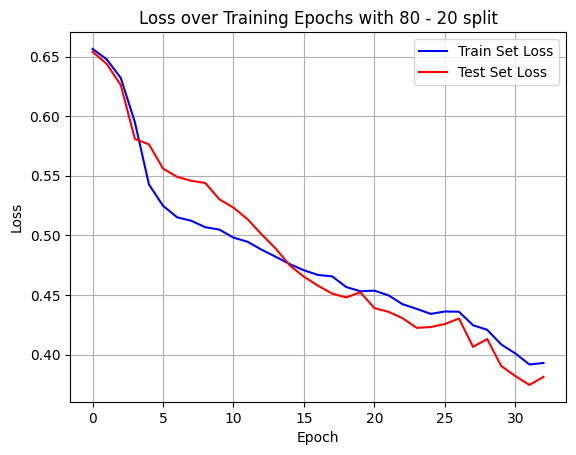

In [64]:
plt.plot(train_losses, color='b', label="Train Set Loss")
plt.plot(test_losses, color='r', label="Test Set Loss")
plt.title(f'Loss over Training Epochs with {round(TRAIN_FRACTION*100)} - {round((1 - TRAIN_FRACTION)*100)} split')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

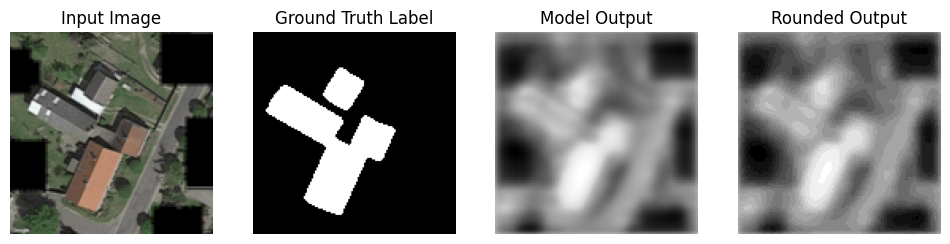

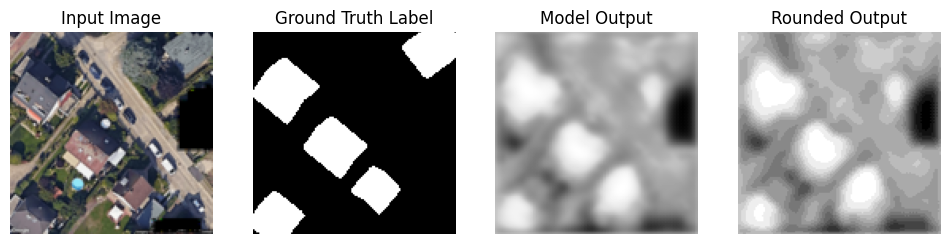

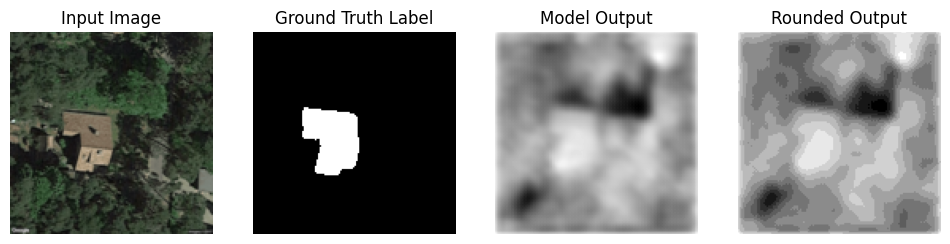

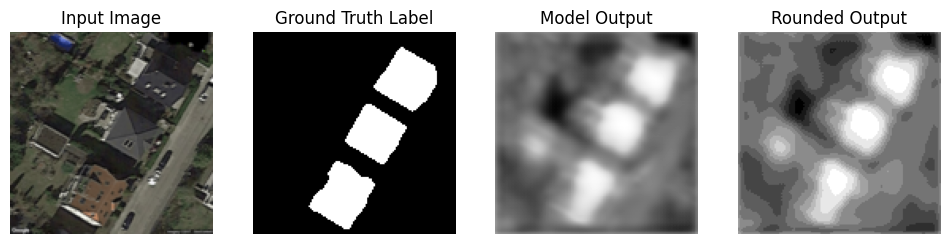

In [ ]:
# Check dataset loading and model output
for images, labels in test_dataloader:
    outputs = model(images)
    visualize_results(images, labels, outputs)
    break